# Robust PCA Intraday Anomaly Detection

In [1]:
import numpy as np
import os
import sys
import pandas as pd
from dateutil import parser
import scipy.sparse

from numpy import linalg as LA

import datetime
import time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

from dimredu.denseSolvers import denseToSparse as denseToSparse
from dimredu.sRPCAviaADMMFast import sRPCA as sRPCA

In [2]:
def get_intraday_returns_df(full_path):
    """Load the data and calculate log return.  Remove the 
    first row because it will always be NaN."""    
    df = pd.read_csv(full_path)
    df.set_index(df['date'], inplace=True)
    df.drop('date', axis=1, inplace=True)
    df_ret = np.log(df / df.shift())
    return df_ret.iloc[1:]

def denseToSparseWithMissingEntries(M, E):
    assert M.shape == E.shape, 'shape mismatch'
    m = M.shape[0]
    n = M.shape[1]

    u_lst = []
    v_lst = []
    vecM_lst = []
    vecE_lst = []
    
    k = 0
    for i in range(m):
        for j in range(n):
            if ~np.isnan(M[i, j]):
                u_lst.append(i)
                v_lst.append(j)
                vecM_lst.append(M[i, j])
                vecE_lst.append(E[i, j])
                k += 1

    u = np.asarray(u_lst)
    v = np.asarray(v_lst)
    vecM = np.asarray(vecM_lst)
    vecE = np.asarray(vecE_lst)
    
    return m, n, u, v, vecM, vecE

def get_scaled_lambda(m, n, _lambda):
    lam = 1. / np.sqrt(np.max([m, n]))
    return lam * _lambda

def get_full_path_2_save(root_dir, filename):
    full_path = os.path.join(root_dir, filename)    
    return full_path

def get_intraday_output_root_dir():
    return r'C:\phd\rpca\output\intraday\2009\returns'

def get_input_dataset(df):
    err = np.ones(df.shape)*1e-6
    m, n, u, v, vecM, vecEpsilon = denseToSparseWithMissingEntries(df.as_matrix(), err)
    maxRank = np.min(df.shape)
    nrows = df.shape[0]
    ncols = df.shape[1]
    return nrows, ncols, maxRank, m, n, u, v, vecM, vecEpsilon

def create_intraday_intermediate_files(df, output_file_name):
    lam_list = [19, 17, 15, 13, 11, 9, 7, 5, 3, 1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 
            0.02, 0.0175, 0.015, 0.0125, 0.010, 0.0075, 0.002]

    # RPCA parameters for experiments
    maxIteration = 1000
    verbose = True

    nrows, ncols, maxRank, m, n, u, v, vecM, vecEpsilon = get_input_dataset(df)
    print("get_input_dataset returned nrows = %d, ncols = %d, maxRank = %d" % (nrows, ncols, maxRank))
    
    for lambda_multiplier in lam_list:    
        actual_lambda = get_scaled_lambda(nrows, ncols, lambda_multiplier)
        print('Now processing lambda multiplier = %4f and actual lambda = %5f' % (lambda_multiplier, actual_lambda))

        output_root_dir = get_intraday_output_root_dir()
        print("output_root_dir = %s" % output_root_dir)
                
        U, E, VT, S, B = sRPCA(m, n, u, v, vecM, vecEpsilon, maxRank, 
                           lam=actual_lambda, mu=None, rho=None, 
                           epsilon1=None, epsilon2=None, 
                           truncateK=0, SOff=False, maxIteration=maxIteration, verbose=verbose)
        filename_prefix = output_file_name + r"_lambda_" + str(lambda_multiplier)
        U.dump(get_full_path_2_save(output_root_dir, filename_prefix + '_U.dat'))
        E.dump(get_full_path_2_save(output_root_dir, filename_prefix + '_E.dat'))
        VT.dump(get_full_path_2_save(output_root_dir, filename_prefix + '_VT.dat'))
        scipy.sparse.save_npz(get_full_path_2_save(output_root_dir, filename_prefix + '_S.npz'), S) # compressed matrix
        scipy.sparse.save_npz(get_full_path_2_save(output_root_dir, filename_prefix + '_B.npz'), B) # compressed matrix

In [13]:
INPUT_DIR = r"C:\phd\rpca\input\intraday\prices\2009"
list_of_files = os.listdir(INPUT_DIR)

In [15]:
# for filename in list_of_files:
#     full_path = INPUT_DIR + "\\" + filename
#     output_file_name, _ = os.path.splitext(filename)
#     df = get_intraday_returns_df(full_path)
#     df = df.round(7)
#     print("Now processing {0}".format(output_file_name))
#     create_intraday_intermediate_files(df, output_file_name)

In [3]:
def load_sparse_matrix(root_dir, date_str, lam):
    file_path = get_full_path_2_save(root_dir, date_str + r'_lambda_' + str(lam) + '_S.npz')
    sparse_matrix = scipy.sparse.load_npz(file_path)
    dense_matrix = sparse_matrix.todense()
    return dense_matrix

def load_sparse_matrix_from_path(file_path):
    sparse_matrix = scipy.sparse.load_npz(file_path)
    dense_matrix = sparse_matrix.todense()
    return dense_matrix

def get_full_path_2_save(root_dir, filename):
    full_path = os.path.join(root_dir, filename)    
    return full_path


In [20]:
output_root_dir = get_intraday_output_root_dir()
some_lambda_multiplier = 1
S = load_sparse_matrix(output_root_dir, "2009-01-05", some_lambda_multiplier)

In [24]:
LA.norm(S, 2)

31.89112866034571

In [27]:
list_of_files = os.listdir(r"C:\phd\rpca\output\intraday\2009\returns")

In [40]:
# l1_norm = []
# l2_norm = []
# for file_name in list_of_files:
#     if "_1_S.npz" in file_name:
#         file_path = r"C:\phd\rpca\output\intraday\2009\returns" + "\\" + file_name
#         print(file_path)
#         S = load_sparse_matrix_from_path(file_path)
#         l1_norm.append(LA.norm(S, 1))
#         l2_norm.append(LA.norm(S, 2))

In [36]:
p_nnz = []
n_nnz = []
z = []
pnr = []

for file_name in list_of_files:
    if "_1_S.npz" in file_name:
        file_path = r"C:\phd\rpca\output\intraday\2009\returns" + "\\" + file_name
        S = load_sparse_matrix_from_path(file_path)
        l1_norm.append(LA.norm(S, 1))
        l2_norm.append(LA.norm(S, 2))    
        P = (S > 0 ).sum(axis=1)
        N = (S < 0 ).sum(axis=1)
        Z = (S == 0).sum(axis=1)
        ratio = P / N
        p_nnz.append(P)
        n_nnz.append(N)
        z.append(Z)
        pnr.append(ratio)
df = pd.DataFrame()
df['P'] = p_nnz
df['N'] = n_nnz
df['Z'] = z
df['pnr'] = pnr

In [62]:
S = load_sparse_matrix_from_path(r"C:\phd\rpca\output\intraday\2009\returns\2009-03-23_lambda_1_S.npz")
S[abs(S) < 0.0001] = 0  
P = (S > 0 ).sum(axis=1)
N = (S < 0 ).sum(axis=1)
Z = (S == 0).sum(axis=1)
ratio = P / N

M = np.concatenate((P, N, Z, ratio), axis=1)
S_df = pd.DataFrame(M, columns=['P', 'N', 'Z', 'PNR'])

In [63]:
S_df.head()

P      N      Z       PNR
0  176.0  169.0  122.0  1.041420
1  171.0  181.0  115.0  0.944751
2  176.0  167.0  124.0  1.053892
3  157.0  188.0  122.0  0.835106
4  145.0  192.0  130.0  0.755208

In [64]:
np.savetxt(r"C:\phd\rpca\debug\S_intraday_2009_03-23.csv", S_df, delimiter=",")

In [57]:
time = pd.read_csv(r"C:\phd\rpca\input\intraday\prices\2009\2009-03-23.csv")

In [61]:
time['date'].to_csv(r"C:\phd\rpca\debug\time.csv")

### Analyze top 5 positive returns 

<table>
    <tr>
        <th>Date</th>
        <th>Positive Return</th>
    </tr>
    <tr>
        <td>3/23/2009</td><td>+7.08%</td>
    </tr>
    <tr>
        <td>3/10/2009</td><td>+6.37%</td>
    </tr>
    <tr>
        <td>1/21/2009</td><td>+4.35%</td>
    </tr>
</table>

In [4]:
S = load_sparse_matrix_from_path(r"C:\phd\rpca\output\intraday\2009\returns\2009-03-23_lambda_1_S.npz")
S[abs(S) < 0.0001] = 0  
P = (S > 0 ).sum(axis=1)
N = (S < 0 ).sum(axis=1)
Z = (S == 0).sum(axis=1)
ratio = P / N

M = np.concatenate((P, N, Z, ratio), axis=1)
S_df = pd.DataFrame(M, columns=['P', 'N', 'Z', 'PNR'])

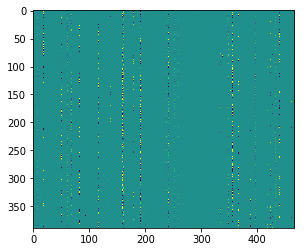

In [14]:
plt.imshow(S, vmin=-1, vmax=1)

In [24]:
S_df.head()

P      N      Z       PNR
0  176.0  169.0  122.0  1.041420
1  171.0  181.0  115.0  0.944751
2  176.0  167.0  124.0  1.053892
3  157.0  188.0  122.0  0.835106
4  145.0  192.0  130.0  0.755208

In [20]:
S_sqr = np.square(S)

In [22]:
S[0:3,0:3]

matrix([[ 0.02279041,  0.        , -0.00283593],
        [ 0.00042289,  0.00858815, -0.00093569],
        [ 0.00361613, -0.00874716,  0.00161386]])

In [23]:
S_sqr[0:3,0:3]

matrix([[5.19402894e-04, 0.00000000e+00, 8.04251347e-06],
        [1.78836668e-07, 7.37562916e-05, 8.75512898e-07],
        [1.30764265e-05, 7.65127416e-05, 2.60455383e-06]])

In [32]:
n_rows = S_sqr.shape[0]
n_cols = S_sqr.shape[1]
col_sums = []
for col_idx in range(n_cols):
    total = 0
    for row_idx in range(n_rows):
        total = total + S_sqr[row_idx, col_idx]
    col_sums.append(total)

In [7]:
df_tickers = pd.read_csv(r"C:\phd\rpca\input\intraday\prices\2009\2009-03-23.csv")

In [50]:
for col_idx in range(len(col_sums)):
#     if col_sums[col_idx] > 50:
        print('{2:s},{1:f}'.format(col_idx, col_sums[col_idx], df_tickers.columns[col_idx+1]))

A,0.000963
AAP,0.000581
AAPL,0.000159
ABC,0.000147
ABT,0.000078
ACN,0.000167
ADBE,0.000191
ADI,0.000106
ADM,7.607179
ADP,0.000170
ADS,0.001013
ADSK,0.000224
AEE,0.000244
AEP,0.860089
AES,130.470782
AET,0.000757
AFL,0.000639
AGN,0.000633
AIG,113.084217
AIV,39.446135
AIZ,0.000340
AJG,0.000214
AKAM,0.000233
AKS,0.001820
ALL,0.000485
ALXN,0.000276
AMAT,0.000248
AMD,0.003254
AME,0.000159
AMG,0.000605
AMGN,0.000106
AMP,0.000873
AMT,0.000240
AMZN,0.000134
AN,0.001228
ANF,0.000687
APA,0.000137
APC,0.000095
APD,0.000069
APH,0.000086
APOL,0.000606
ASH,0.000837
ATI,0.000695
ATVI,0.000453
AVB,0.000462
AVP,0.000601
AVY,0.499200
AXP,0.001464
AZO,0.000168
BA,0.000148
BAC,711.410057
BAX,0.000117
BBBY,0.000287
BBT,3.929831
BBY,0.000413
BCR,0.000050
BDX,0.000099
BEN,0.000453
BHI,0.000240
BIG,0.000324
BIIB,0.000115
BK,18.529634
BLL,0.000120
BMS,0.000293
BMY,0.000088
BSX,0.000596
BWA,0.000474
BXP,0.000569
C,34.713464
CA,0.000215
CAG,0.000227
CAH,0.000114
CAT,0.000488
CB,0.000190
CBG,0.007694
CBS,0.023785


In [54]:
vals = []
row_index = []
col_index = []
for col_idx in range(n_cols):
    for row_idx in range(n_rows):
        row_index.append(row_idx)
        col_index.append(col_idx)
        vals.append(S_sqr[row_idx, col_idx])

In [55]:
arr = np.array(vals)
arr.argsort()[-5:][::-1]

array([76808, 76809, 76806, 76897, 76815], dtype=int64)

In [5]:
n_rows = S.shape[0]
n_cols = S.shape[1]
col_vals = []
for col_idx in range(n_cols):
    total = 0
    for row_idx in range(n_rows):
        total = total + S[row_idx, col_idx]
    col_vals.append(total)

In [8]:
for col_idx in range(len(col_vals)):
    print('{2:s},{1:f}'.format(col_idx, col_vals[col_idx], df_tickers.columns[col_idx+1]))

A,0.013171
AAP,-0.022844
AAPL,0.014169
ABC,0.001382
ABT,-0.010851
ACN,0.004596
ADBE,0.021742
ADI,-0.004957
ADM,0.298976
ADP,0.001451
ADS,0.068545
ADSK,0.024211
AEE,-0.002821
AEP,0.006034
AES,0.003332
AET,-0.017357
AFL,0.013203
AGN,0.020382
AIG,-0.067370
AIV,-0.895051
AIZ,0.014421
AJG,-0.004894
AKAM,0.016310
AKS,-0.023652
ALL,0.011757
ALXN,0.010820
AMAT,0.006265
AMD,0.009318
AME,0.012237
AMG,0.040588
AMGN,0.001942
AMP,0.024506
AMT,-0.011480
AMZN,0.012629
AN,0.045756
ANF,-0.002426
APA,0.011210
APC,0.003810
APD,-0.016408
APH,-0.002004
APOL,-0.004290
ASH,0.049296
ATI,0.020987
ATVI,-0.013438
AVB,0.011552
AVP,-0.001883
AVY,0.002236
AXP,0.016096
AZO,-0.013545
BA,0.019692
BAC,-0.178159
BAX,0.001165
BBBY,-0.003321
BBT,-0.208743
BBY,-0.004252
BCR,0.011242
BDX,0.001340
BEN,0.020122
BHI,0.023813
BIG,-0.001368
BIIB,0.007879
BK,0.035496
BLL,-0.003976
BMS,-0.011514
BMY,0.003078
BSX,-0.012617
BWA,0.027628
BXP,0.016613
C,-0.037356
CA,0.015328
CAG,-0.000232
CAH,0.003185
CAT,0.000773
CB,-0.019510
CBG,0.0

In [45]:
df_tickers.columns[448]

'WFC'

### Analyze top 5 negative returns 

<table>
    <tr>
        <th>Date</th>
        <th>Negative Return</th>
    </tr>
    <tr>
        <td>1/20/2009</td><td>-5.28%</td>
    </tr>
    <tr>
        <td>2/10/2009</td><td>-4.91%</td>
    </tr>
    <tr>
        <td>3/2/2009</td><td>-4.66%</td>
    </tr>
</table>